In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import os
from collections import defaultdict

pd.set_option("display.max_rows",10)

**Loading data**

In [159]:
train = pd.read_csv('train.csv', sep=',', encoding='utf8')
test = pd.read_csv('test.csv', sep=',', encoding='utf8')
print("Training set shape: {} \nTest set shape: {}".format(train.shape, test.shape))

Training set shape: (159571, 8) 
Test set shape: (153164, 2)


In [160]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [161]:
# no missing value
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [162]:
# Checking statistics of the labels in the training set
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


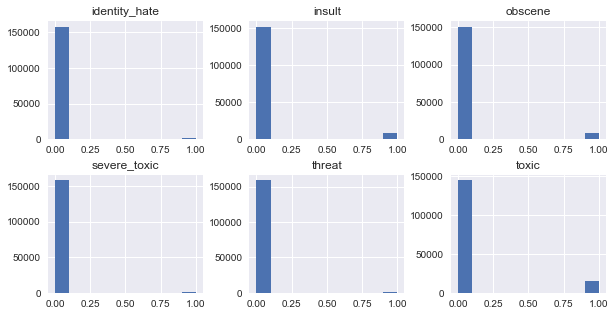

In [163]:
# visuallize the distribution of value for different labels
train.hist(figsize=(10,5), layout=(2,3))
plt.show()

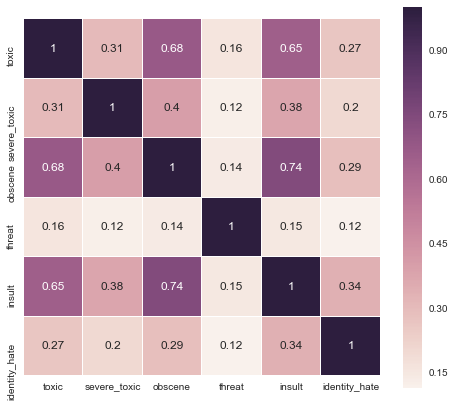

In [164]:
# checking correlation of different lables

# sns.set(font_scale=1.5)
# plt.yticks(rotation=0)

plt.figure(figsize=(8,7))
sns.heatmap(train.iloc[:,2:].corr(method='spearman'), annot=True, square=True, linewidths=0.1)
plt.show()

**Text preprocessing** <br>


In [165]:
import spacy
nlp = spacy.load('en_core_web_lg') 

from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [166]:
# update punctuation in spacy
nlp.vocab["$"].is_punct = True
nlp.vocab["|"].is_punct = True
nlp.vocab["+"].is_punct = True
nlp.vocab["<"].is_punct = True
nlp.vocab[">"].is_punct = True
nlp.vocab["="].is_punct = True
nlp.vocab["^"].is_punct = True
nlp.vocab["`"].is_punct = True
nlp.vocab["~"].is_punct = True

In [167]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [171]:
def nlp_to_remove(token):
    return(token.is_stop or                                                # remove stop words
           token.is_punct or                                               # reomve punctuations
           token.is_space or                                               # remove white space char
           token.lemma_=='-PRON-'                                          # fixing '-PRON-' issue
           )

def nlp_pip(comment_column, n_cores=cores):
    res = defaultdict(list)
    n = 0
    start_time = time.time()
    for doc in nlp.pipe(comment_column, n_threads=cores):
        filtered_tokens = [token for token in doc if not nlp_to_remove(token)]
        m = len(filtered_tokens)
        if m>0:
            res['caps'].append(sum([token.is_upper for token in filtered_tokens])/m)          # percentage of upper words
            res['longest_word'].append(max([len(token) for token in filtered_tokens]))        # length of the longest word
        else:
            res['caps'].append(0)
            res['longest_word'].append(0)
        lemma_token = [token.lemma_.lower() for token in filtered_tokens]
        res['tokenized'].append(lemma_token)                                                  # list of tokens
        res['cleaned_text'].append(' '.join(lemma_token))                                     # recombined text
        res['len_doc'].append(len(doc))                                                       # number of char
        res['n_words'].append(m)                                                              # number of words
        res['oov'].append(sum([token.is_oov for token in filtered_tokens]))                   # count of out of vocabulary words 
        n += 1
        if n%10000 ==0:
            print("finished {} iterattions, elapsed time: {:.2f} min".format(n, (time.time()-start_time)/60))
    return(res)

def token_to_remove(token):    
    return(token.is_punct or 
           token.is_space or 
           token.lemma_.lower() in nlp.Defaults.stop_words                                   # is_stop not working with lg model
           )
    
def token_pip(comment_column, n_cores=cores):
    res = defaultdict(list)
    n = 0
    start_time = time.time()
    for doc in tokenizer.pipe(comment_column, n_threads=cores):
        filtered_tokens = [token for token in doc if not token_to_remove(token)]
        m = len(filtered_tokens)
        if m>0:
            res['caps'].append(sum([token.is_upper for token in filtered_tokens])/m)          # percentage of upper words
            res['longest_word'].append(max([len(token) for token in filtered_tokens]))        # length of the longest word
        else:
            res['caps'].append(0)
            res['longest_word'].append(0)
        lemma_token = [token.lemma_.lower() for token in filtered_tokens]
#         res['tokenized'].append([token.lemma_.lower() for token in filtered_tokens])        
        res['cleaned_text'].append(' '.join(lemma_token))                                     # recombined text
        res['len_doc'].append(len(doc))                                                       # number of char
        res['n_words'].append(m)                                                              # number of words
        res['oov'].append(sum([token.is_oov for token in filtered_tokens]))                   # count of out of vocabulary words 
        n += 1
        if n%10000 ==0:
            print("finished {} iterattions, elapsed time: {:.2f} s".format(n, time.time()-start_time))
    return(res)

def token_combine(nested_list):
    combined_doc = []
    for i in range(len(nested_list)):
        combined_doc.append(' '.join(nested_list[i]))
    return(combined_doc)

In [169]:
# remove urls leaving only http/https

train.comment_text = train.comment_text.apply(lambda x: re.sub(r"(https|http)\S+", "", x))
train.comment_text = train.comment_text.apply(lambda x: re.sub(r'[0-9]+(\.[0-9]+){3}', 'ipaddress', x))
train.comment_text = train.comment_text.apply(lambda x: re.sub(r'([{}])'.format(string.punctuation),' \g<1> ', x))        # “”¨«»®´·º½¾¿¡§£₤‘’

In [172]:
%%time

if not os.path.exists('train_tokenize.pkl') or 1==1:
    print("start processing text...")
#     features_nlp = nlp_pip(train.comment_text)            # this one takes long time
    features_tokenizer = token_pip(train.comment_text)      # this one much faster
    for k in features_tokenizer:
        train[k] = features_tokenizer[k]
    train_tokenize = train.copy()
    print('Saving dataframe...')
    train.to_pickle('train_tokenize.pkl')
else:
    train_tokenize = pd.read_pickle('train_tokenize.pkl')

start processing text...
finished 10000 iterattions, elapsed time: 4.39 s
finished 20000 iterattions, elapsed time: 8.52 s
finished 30000 iterattions, elapsed time: 12.50 s
finished 40000 iterattions, elapsed time: 16.59 s
finished 50000 iterattions, elapsed time: 20.58 s
finished 60000 iterattions, elapsed time: 24.75 s
finished 70000 iterattions, elapsed time: 28.82 s
finished 80000 iterattions, elapsed time: 32.99 s
finished 90000 iterattions, elapsed time: 38.18 s
finished 100000 iterattions, elapsed time: 42.26 s
finished 110000 iterattions, elapsed time: 46.42 s
finished 120000 iterattions, elapsed time: 50.48 s
finished 130000 iterattions, elapsed time: 54.49 s
finished 140000 iterattions, elapsed time: 58.56 s
finished 150000 iterattions, elapsed time: 62.72 s
Saving dataframe...
Wall time: 1min 8s


In [173]:
train_tokenize

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,caps,longest_word,cleaned_text,len_doc,n_words,oov
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0.040000,11,explanation edit username hardcore metallica f...,58,25,0
1,000103f0d9cfb60f,D ' aww ! He matches this background colour I...,0,0,0,0,0,0,0.133333,10,d aww match background colour seemingly stick ...,39,15,0
2,000113f07ec002fd,"Hey man , I ' m really not trying to edit war...",0,0,0,0,0,0,0.000000,11,hey man try edit war s guy constantly remove r...,53,20,0
3,0001b41b1c6bb37e,""" \nMore\nI can ' t make any real suggestions...",0,0,0,0,0,0,0.000000,11,t real suggestion improvement wonder section s...,154,49,0
4,0001d958c54c6e35,"You , sir , are my hero . Any chance you re...",0,0,0,0,0,0,0.000000,8,sir hero chance remember page s,22,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""" : : : : : And for the second time of a...",0,0,0,0,0,0,0.000000,11,2 time ask view completely contradict coverage...,81,20,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0.000000,9,ashamed horrible thing talk page ipaddress,21,6,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm , theres no actual article fo...",0,0,0,0,0,0,0.000000,12,spitzer umm theres actual article prostitution...,19,9,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,0.000000,8,look like actually speedy ﻿1 version delete look,26,8,0


**check an example**

In [174]:
idx = list(train.id).index('001956c382006abd')
print(train_tokenize.comment_text[idx])
print(train_tokenize.cleaned_text[idx])

I ' m Sorry 

I ' m sorry I screwed around with someones talk page .   It was very bad to do .   I know how having the templates on their talk page helps you assert your dominance over them .   I know I should bow down to the almighty administrators .   But then again ,  I ' m going to go play outside .  .  .  . with your mom .    ipaddress
sorry sorry screw someones talk page bad know template talk page help assert dominance know bow almighty administrator play outside mom ipaddress


**Some more EDA**

In [20]:
from itertools import chain
print('number of unique words: {}'.format(len(set(chain(*train_tokenize.tokenized)))))

number of unique words: 194659


In [132]:
# Checking features generated
train_tokenize.iloc[:, 8:].describe()

,caps,longest_word,len_doc,n_words,oov
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.057222,10.918738,96.704545,68.522018,1.138897
std,0.123454,34.430522,151.759113,101.552700,5.488542
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,25.000000,17.000000,0.000000
50%,0.029851,11.000000,52.000000,36.000000,0.000000
75%,0.064516,12.000000,106.000000,77.000000,1.000000
max,1.000000,4955.000000,9889.000000,1403.000000,624.000000


In [25]:
# there are some comments that ended up with no token after processing
train_tokenize[train_tokenize.n_words==0]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,caps,longest_word,tokenized,cleaned_text,len_doc,n_words,oov
6193,1089bc2866ce9379,71.223.125.139,0,0,0,0,0,0,0.0,0,[],,2,0,0
9395,18ed60f8e586bcbd,They do too. their ... -,0,0,0,0,0,0,0.0,0,[],,8,0,0
10091,1aaffdb69433956e,I might as well give up then.,0,0,0,0,0,0,0.0,0,[],,8,0,0
12691,21a84f3772e4fae6,""", and """" is another""",0,0,0,0,0,0,0.0,0,[],,8,0,0
17173,2d4d2f84cd40cf4f,and :here where it has always been,0,0,0,0,0,0,0.0,0,[],,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147027,35b128fb301e11fe,They are not mine.,0,0,0,0,0,0,0.0,0,[],,5,0,0
147665,3ff4333a2976c327,\n \n,0,0,0,0,0,0,0.0,0,[],,1,0,0
148563,4eb333746ee70a45,", how about one of these for you??",0,0,0,0,0,0,0.0,0,[],,10,0,0
148865,5352b339650c4138,she did 76.122.79.82,0,0,0,0,0,0,0.0,0,[],,3,0,0


In [26]:
# abnormal long word
train_tokenize[train_tokenize.longest_word>100]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,caps,longest_word,tokenized,cleaned_text,len_doc,n_words,oov
1876,0512b588a4b80e45,YOUR ARE FUCKING GAY WAD!!!!!!!!!!!!!!!!!!!!!!...,1,0,1,0,1,1,0.865169,322,"[your, are, fucking, gay, wad, fuck, mum, oh, ...",your are fucking gay wad fuck mum oh wait your...,309,89,89
11796,1f31848ca28571da,==U R GAY== \n\nFUCKFUCKFUCKFUCKFUCKFUCKFUCKFU...,1,1,1,0,1,1,0.666667,4955,"[=, =, u, r, gay==, fuckfuckfuckfuckfuckfuckfu...",= = u r gay== fuckfuckfuckfuckfuckfuckfuckfuck...,7,6,6
12964,2256374810e57006,"Hello, 24-7水野, and welcome to Wikipedia! While...",0,0,0,0,0,0,0.000000,103,"[hello, 24, 7水野, welcome, wikipedia, while, ef...",hello 24 7水野 welcome wikipedia while effort im...,83,33,33
17945,2f6282bf19d1b9ce,Yamla_likes_to_fuck_babies_up_the_ass_wwwwwwww...,1,0,1,0,1,0,0.000000,170,[yamla_likes_to_fuck_babies_up_the_ass_wwwwwww...,yamla_likes_to_fuck_babies_up_the_ass_wwwwwwww...,22,10,10
18888,31d9e971fd76329d,Small TextInsert non-formatted text here[[Medi...,0,0,0,0,0,0,0.000000,1422,"[small, textinsert, non, format, text, here[[m...",small textinsert non format text here[[media m...,41,24,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134086,cd1f1e8d669b1df8,Oh Really ?\n\nhahahahahahahahahahhahahahhhahh...,0,0,0,0,0,0,0.375000,113,"[oh, really, hahahahahahahahahahhahahahhhahhah...",oh really hahahahahahahahahahhahahahhhahhahaha...,13,8,8
144621,0fd85e97c0b88732,ASSHOLE \nYOU ARE AN ASSHOLE WIKI NAZI! \n\nFR...,1,0,1,0,1,0,0.955556,127,"[asshole, you, are, an, asshole, wiki, nazi, f...",asshole you are an asshole wiki nazi freedom!f...,119,45,45
144947,15187c3925194c1a,4th/ August \n\nw0000000000000000tw00000000000...,0,0,0,0,0,0,0.090909,737,"[4th/, august, w0000000000000000tw000000000000...",4th/ august w0000000000000000tw000000000000000...,18,11,11
149103,571b7305218a37d7,"""Hello, 梁智前, and welcome to Wikipedia! While e...",0,0,0,0,0,0,0.000000,106,"[hello, 梁智前, welcome, wikipedia, while, effort...",hello 梁智前 welcome wikipedia while effort impro...,82,32,32


In [31]:
# abnormal number of oov words
train_tokenize[train_tokenize.oov>500]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,caps,longest_word,tokenized,cleaned_text,len_doc,n_words,oov
126,00510c3d06745849,"Ahh, Hello Witzeman \n\n203.92.84.161 \nSymbo...",0,0,0,0,0,0,0.242079,14,"[ahh, hello, witzeman, symbol, ~, |, ↔, ↑, ↓, ...",ahh hello witzeman symbol ~ | ↔ ↑ ↓ ½ ⅓ ⅔ ¼ ¾ ...,1203,789,789
2366,065b10e83e654132,User:NHRHS2010 is a homo like mitt romney is. ...,1,0,1,0,1,1,0.077187,9,"[user, nhrhs2010, homo, like, mitt, romney, us...",user nhrhs2010 homo like mitt romney user nhrh...,1044,583,583
2420,067c5e814e88a56b,FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT ...,1,1,1,0,1,0,1.000000,7,"[fuck, you, u, useless, bot, fuck, you, u, use...",fuck you u useless bot fuck you u useless bot ...,1087,1087,1087
4174,0b2055f13934a41e,ii CAN STILL POST WITH THIS COMPUTER...I SAID ...,1,0,1,0,1,0,0.965000,11,"[ii, can, still, post, with, this, computer, s...",ii can still post with this computer say block...,965,800,800
4712,0c7c341727488579,do go fuck off bastard\nDo Yyou Have a life?\n...,1,1,1,1,1,0,0.000000,8,"[fuck, bastard, do, yyou, have, life, fuck, ba...",fuck bastard do yyou have life fuck bastard ya...,2089,702,702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153907,a4da3c2e960ae064,btw mark arsten is a son of a bitch his cock i...,1,0,1,0,1,0,0.000000,9,"[btw, mark, arsten, son, bitch, cock, place, g...",btw mark arsten son bitch cock place girl mout...,840,666,666
154181,a9bc2dafcbd640b7,tYOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE ...,1,1,1,0,1,0,0.998246,10,"[tyou, are, a, mothjer, fucker, cocksucker, yo...",tyou are a mothjer fucker cocksucker you are a...,665,570,570
155610,c0b66a468cfb4fe6,"""\n\nConverses, they are amazing. if you are ""...",0,0,0,0,0,0,0.021401,16,"[converse, amazing, gangsta, wonder, <3, when,...",converse amazing gangsta wonder <3 when u.s. e...,1004,514,514
156032,c7e2a95e8146e108,AIDS AIDS AIDS AIDS AIDS AIDS AIDSAIDS AIDS AI...,1,0,0,0,0,0,1.000000,8,"[aids, aids, aids, aids, aids, aids, aidsaids,...",aids aids aids aids aids aids aidsaids aids ai...,883,883,883


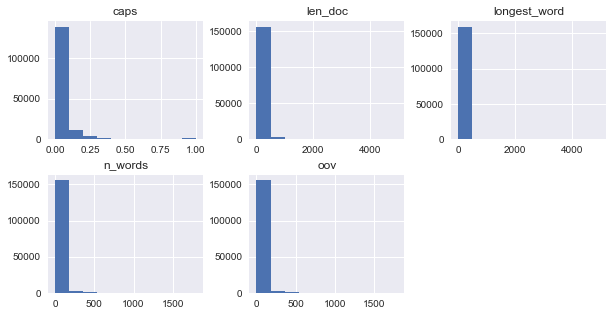

In [32]:
# visuallize the distribution of features
train_tokenize.iloc[:, 8:].hist(figsize=(10,5), layout=(2,3))
plt.show()

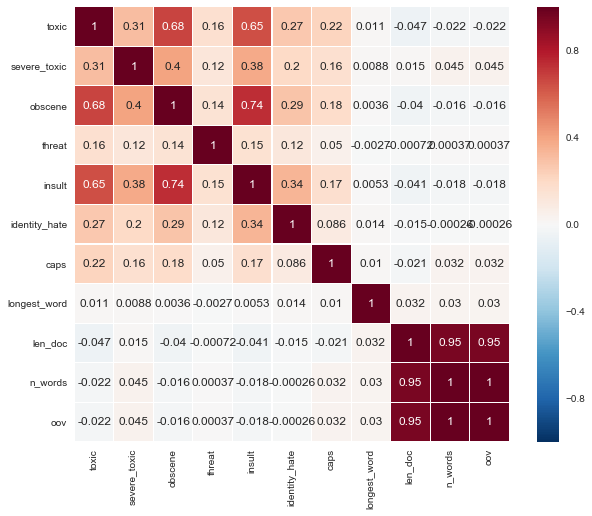

In [33]:
# checking correlation

plt.figure(figsize=(10,8))
sns.heatmap(train_tokenize.iloc[:,2:].corr(), annot=True, square=True, linewidths=0.1)
plt.show()

## Modeling

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV

In [36]:
from sklearn import metrics

# def evaluate_model(clf, actual, predicted):
#     """Scores a model with the created train and test sets."""
#     train_loss = metrics.roc_auc_score(y_train, clf.predict_proba(x_train)[:,1])
#     test_loss = metrics.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1])
#     matrix = confusion_matrix(actual, predicted)
#     report = metrics.classification_report(actual, predicted, target_names = ['0', '1'])
#     print("Train score:", train_loss)
#     print("Test score:", test_loss)
#     print('Confusion Matrix:\n', matrix)
#     print('Classification report:\n', report)

#     return test_loss

**for one label: toxic**

In [41]:
x_train, x_test, y_train, y_test = train_test_split(train_tokenize.cleaned_text, 
                                                    train_tokenize['toxic'], 
                                                    test_size = 0.2, 
                                                    stratify = train_tokenize['toxic'])
pipe_nb_toxic = Pipeline([('tfidf', TfidfVectorizer()), ('nb', MultinomialNB())])

In [51]:
parameters = {'tfidf__max_df': (0.70, 0.80, 0.90, 1.0),\
              'tfidf__min_df': (0, 0.01,0.03,0.1),\
              'nb__alpha': (1, 0.3, 0.1, 0.03, 0.01, 0.003)}
gs_nb_toxic = GridSearchCV(pipe_nb_toxic, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=10)

In [52]:
%%time

gs_nb_toxic.fit(x_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.6min
[Paralle

Wall time: 20min 10s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...True,
        vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'tfidf__max_df': (0.7, 0.8, 0.9, 1.0), 'tfidf__min_df': (0, 0.01, 0.03, 0.1), 'nb__alpha': (1, 0.3, 0.1, 0.03, 0.01, 0.003)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=10)

In [53]:
gs_nb_toxic.best_params_

{'nb__alpha': 0.03, 'tfidf__max_df': 0.7, 'tfidf__min_df': 0}

In [66]:
gs_nb_toxic.best_score_

0.9426850756559979

In [65]:
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, gs_nb_toxic.predict_proba(x_train)[:,1])))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, gs_nb_toxic.predict_proba(x_test)[:,1])))

C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Training score(roc_auc): 0.987459821357174
Test score(roc_auc): 0.9482863041090147


In [76]:
metrics.confusion_matrix(y_test, gs_nb_toxic.predict(x_test))

C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


array([[28585,   271],
       [ 1380,  1679]], dtype=int64)

C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


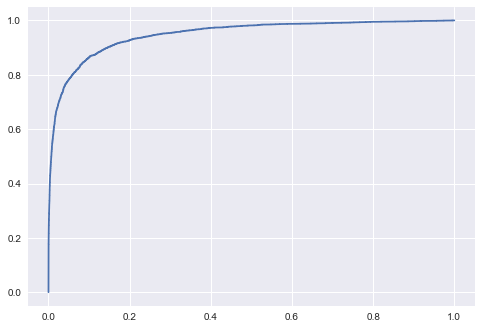

In [70]:
a = metrics.roc_curve(y_test, gs_nb_toxic.predict_proba(x_test)[:,1])
plt.plot(a[0],a[1])
plt.show()

In [ ]:
pip = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('split', TestTrainSplitor()),
            ('mnb', MultinomialNB())
            ])

issue:
  - is_stop dose not work with en_core_web_lg, works with en_core_web_sm
  - is_oov dose not work with en_core_web_sm, works with en_core_web_lg

notes:
 - keep -PRON-
 - ngrams?
 - vector from en_core_web_lg token?
 - faster tokenizer?
 
 
   

data: 
   - v1. en_core_web_lg, nlp.pip, is_stop dose not work with lg model, http address not removed
   - v2. en_core_web_sm, nlp.pip, stop words removed, http address removed, is_oov dose not work with sm model
   - v3. en_core_web_lg, tokenize.pip http address removed, stop word remove fixed, is_oov working